In [5]:
import pandas as pd 
%pip install openpyxl


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
xls= pd.ExcelFile("global_superstore_2016.xlsx")
xls.sheet_names

['Orders', 'Returns', 'People']

In [19]:
orders = pd.read_excel(xls, sheet_name="Orders", engine='openpyxl')
people = pd.read_excel(xls, sheet_name="People", engine='openpyxl')
returns = pd.read_excel(xls, sheet_name="Returns", engine='openpyxl')

In [8]:
print(orders.head())

   Row ID                  Order ID Order Date  Ship Date     Ship Mode  \
0   40098  CA-2014-AB10015140-41954 2014-11-11 2014-11-13   First Class   
1   26341    IN-2014-JR162107-41675 2014-02-05 2014-02-07  Second Class   
2   25330    IN-2014-CR127307-41929 2014-10-17 2014-10-18   First Class   
3   13524   ES-2014-KM1637548-41667 2014-01-28 2014-01-30   First Class   
4   47221   SG-2014-RH9495111-41948 2014-11-05 2014-11-06      Same Day   

    Customer ID     Customer Name      Segment  Postal Code           City  \
0  AB-100151402     Aaron Bergman     Consumer      73120.0  Oklahoma City   
1     JR-162107     Justin Ritter    Corporate          NaN     Wollongong   
2     CR-127307      Craig Reiter     Consumer          NaN       Brisbane   
3    KM-1637548  Katherine Murray  Home Office          NaN         Berlin   
4    RH-9495111       Rick Hansen     Consumer          NaN          Dakar   

   ...   Product ID    Category Sub-Category  \
0  ...  TEC-PH-5816  Technology 

In [9]:
print(people.head())

              Person           Region
0  Marilène Rousseau        Caribbean
1   Andile Ihejirika   Central Africa
2  Nicodemo Bautista  Central America
3     Cansu Peynirci     Central Asia
4         Lon Bonher       Central US


In [10]:
orders['Order Date']= pd.to_datetime(orders['Order Date'],errors='coerce')
orders['Ship Date'] = pd.to_datetime(orders['Ship Date'], errors='coerce')

# Convert Sales and Profit to numeric (in case they're stored as text)
orders['Sales'] = pd.to_numeric(orders['Sales'], errors='coerce')
orders['Profit'] = pd.to_numeric(orders['Profit'], errors='coerce')


In [11]:
len(orders)

51290

In [12]:
orders.dropna(subset=['Order ID','Order Date','Sales','Profit'],inplace=True)

In [13]:
len(orders)

51290

In [14]:
order_people = orders.merge(people,how='right',on='Region')
print(order_people.head())
print(len(order_people))

   Row ID                 Order ID Order Date  Ship Date       Ship Mode  \
0   220.0  US-2012-RR1952536-41270 2012-12-27 2012-12-29    Second Class   
1  2641.0  US-2012-LH1675036-41129 2012-08-08 2012-08-08        Same Day   
2   879.0  MX-2015-TM2149031-42329 2015-11-21 2015-11-21        Same Day   
3  5306.0  MX-2015-TB2125031-42289 2015-10-12 2015-10-15     First Class   
4  6019.0  MX-2013-JF1529531-41564 2013-10-17 2013-10-21  Standard Class   

  Customer ID   Customer Name    Segment  Postal Code              City  ...  \
0  RR-1952536       Rick Reed  Corporate          NaN     Santo Domingo  ...   
1  LH-1675036    Larry Hughes   Consumer          NaN     Santo Domingo  ...   
2  TM-2149031   Tony Molinari   Consumer          NaN          Camagüey  ...   
3  TB-2125031    Tim Brockman   Consumer          NaN  Santiago de Cuba  ...   
4  JF-1529531  Jason Fortune-   Consumer          NaN        Guantánamo  ...   

     Category Sub-Category                                 Pro

In [15]:
order_people.to_csv("cleaned_orders.csv",index=False)

In [16]:
import sqlite3

In [17]:
conn = sqlite3.connect("retail_project.db")

In [23]:
orders.to_sql("Orders",conn)

ProgrammingError: Cannot operate on a closed database.

In [22]:
import sqlite3

# Connect to SQLite DB (it will create one)
conn = sqlite3.connect("retail_project.db")

# Store individual tables and merged table
orders.to_sql("Orders", conn, if_exists="replace", index=False)
people.to_sql("People", conn, if_exists="replace", index=False)
returns.to_sql("Returns", conn, if_exists="replace", index=False)
order_people.to_sql("OrdersPeople", conn, if_exists="replace", index=False)

conn.close()


In [25]:
import sqlite3
conn = sqlite3.connect("retail_project.db")

query = """
SELECT Region, 
       SUM(Sales) AS Total_Sales, 
       SUM(Profit) AS Total_Profit
FROM OrdersPeople
GROUP BY Region
ORDER BY Total_Sales DESC;
"""

result = pd.read_sql_query(query, conn)
print(result)

conn.close()


               Region   Total_Sales  Total_Profit
0      Western Europe  1.731930e+06  218433.50850
1     Central America  1.223101e+06  158981.64816
2             Oceania  1.100185e+06  120089.11200
3   Southeastern Asia  8.844232e+05   17852.32900
4       Southern Asia  8.665727e+05  159336.42700
5        Eastern Asia  8.550594e+05  167101.85100
6          Western US  7.254578e+05  108418.44890
7          Eastern US  6.787812e+05   91522.78000
8     Northern Europe  6.367792e+05   83923.91700
9       South America  6.172237e+05   28090.51788
10    Southern Europe  6.085940e+05   70109.41800
11         Central US  5.012399e+05   39706.36250
12        Southern US  3.917219e+05   46749.43030
13          Caribbean  3.242809e+05   34571.32104
14       Western Asia  3.171070e+05  -53921.67000
15     Eastern Europe  3.100334e+05   77084.88000
16       North Africa  2.332166e+05   57836.25000
17     Western Africa  1.738788e+05  -50407.78800
18     Central Africa  1.436300e+05   35383.71000


In [32]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("retail_project.db")

# Define queries
queries = {
    "Sales_by_Region": """
        SELECT Region, SUM(Sales) AS Total_Sales, SUM(Profit) AS Total_Profit
        FROM OrdersPeople GROUP BY Region ORDER BY Total_Sales DESC;
    """,
    "Monthly_Sales": """
        SELECT strftime('%Y-%m', [Order Date]) AS Month, SUM(Sales) AS Monthly_Sales
        FROM OrdersPeople GROUP BY Month ORDER BY Month;
    """,
    
    "Top_5_Sales_Reps": """
        SELECT category,SUM(Profit) AS Total_Profit
        FROM OrdersPeople GROUP BY category ORDER BY Total_Profit DESC LIMIT 5;
    """,
    "Most_Returned_Products": """
       SELECT [Product ID], SUM(Quantity) AS Total_Quantity
FROM OrdersPeople
GROUP BY [Product ID]
ORDER BY Total_Quantity DESC
LIMIT 10;
    """
}

# Export to Excel
with pd.ExcelWriter("Retail_Dashboard_Data.xlsx", engine='openpyxl') as writer:
    for sheet, query in queries.items():
        df = pd.read_sql_query(query, conn)
        df.to_excel(writer, sheet_name=sheet, index=False)

conn.close()


In [31]:
import sqlite3

conn = sqlite3.connect('retail_project.db')
cursor = conn.cursor()
cursor.execute("PRAGMA table_info(OrdersPeople);")
for row in cursor.fetchall():
    print(row)
conn.close()

(0, 'Row ID', 'REAL', 0, None, 0)
(1, 'Order ID', 'TEXT', 0, None, 0)
(2, 'Order Date', 'TIMESTAMP', 0, None, 0)
(3, 'Ship Date', 'TIMESTAMP', 0, None, 0)
(4, 'Ship Mode', 'TEXT', 0, None, 0)
(5, 'Customer ID', 'TEXT', 0, None, 0)
(6, 'Customer Name', 'TEXT', 0, None, 0)
(7, 'Segment', 'TEXT', 0, None, 0)
(8, 'Postal Code', 'REAL', 0, None, 0)
(9, 'City', 'TEXT', 0, None, 0)
(10, 'State', 'TEXT', 0, None, 0)
(11, 'Country', 'TEXT', 0, None, 0)
(12, 'Region', 'TEXT', 0, None, 0)
(13, 'Market', 'TEXT', 0, None, 0)
(14, 'Product ID', 'TEXT', 0, None, 0)
(15, 'Category', 'TEXT', 0, None, 0)
(16, 'Sub-Category', 'TEXT', 0, None, 0)
(17, 'Product Name', 'TEXT', 0, None, 0)
(18, 'Sales', 'REAL', 0, None, 0)
(19, 'Quantity', 'REAL', 0, None, 0)
(20, 'Discount', 'REAL', 0, None, 0)
(21, 'Profit', 'REAL', 0, None, 0)
(22, 'Shipping Cost', 'REAL', 0, None, 0)
(23, 'Order Priority', 'TEXT', 0, None, 0)
(24, 'Person', 'TEXT', 0, None, 0)


In [35]:
print("Orders columns:", orders.columns.tolist())
print("People columns:", people.columns.tolist())

Orders columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Postal Code', 'City', 'State', 'Country', 'Region', 'Market', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority']
People columns: ['Person', 'Region']


In [36]:
# ... previous code unchanged ...

# ---------- 🔹 TRANSFORM ----------
# Clean date and numeric columns
orders['Order Date'] = pd.to_datetime(orders['Order Date'], errors='coerce')
orders['Ship Date'] = pd.to_datetime(orders['Ship Date'], errors='coerce')
orders['Sales'] = pd.to_numeric(orders['Sales'], errors='coerce')
orders['Profit'] = pd.to_numeric(orders['Profit'], errors='coerce')

# Drop rows with essential missing data
orders.dropna(subset=['Order ID', 'Order Date', 'Sales', 'Profit'], inplace=True)

# Ensure returns have flag
returns['Returned'] = True

# Add return flag directly to orders
orders['Returned'] = orders['Order ID'].isin(returns['Order ID']).astype(int)

# ---------- 🔹 LOAD (CSV + SQLite) ----------
# Save as CSV
orders.to_csv("cleaned_orders.csv", index=False)

# Save to SQLite DB
conn = sqlite3.connect("retail_project.db")
orders.to_sql("Orders", conn, if_exists="replace", index=False)
people.to_sql("People", conn, if_exists="replace", index=False)
returns.to_sql("Returns", conn, if_exists="replace", index=False)

# ---------- 🔹 LOAD (Excel Sheets for Dashboard) ----------
queries = {
    "Sales_by_Region": """
        SELECT Region, SUM(Sales) AS Total_Sales, SUM(Profit) AS Total_Profit
        FROM Orders GROUP BY Region ORDER BY Total_Sales DESC;
    """,
    "Monthly_Sales": """
        SELECT strftime('%Y-%m', [Order Date]) AS Month, SUM(Sales) AS Monthly_Sales
        FROM Orders GROUP BY Month ORDER BY Month;
    """,
    "Return_Rate_by_Region": """
        SELECT Region,
               COUNT(CASE WHEN Returned = 1 THEN 1 END) * 1.0 / COUNT(*) AS Return_Rate
        FROM Orders GROUP BY Region ORDER BY Return_Rate DESC;
    """,
    "Most_Returned_Products": """
        SELECT [Product Name], COUNT(*) AS Return_Count
        FROM Orders WHERE Returned = 1 GROUP BY [Product Name]
        ORDER BY Return_Count DESC LIMIT 10;
    """
}

with pd.ExcelWriter("Retail_Dashboard_Data.xlsx", engine='openpyxl') as writer:
    for name, q in queries.items():
        df = pd.read_sql_query(q, conn)
        df.to_excel(writer, sheet_name=name, index=False)

conn.close()
print("✅ ETL pipeline complete! Data cleaned, saved, and ready.")

✅ ETL pipeline complete! Data cleaned, saved, and ready.


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_orders.csv", parse_dates=["Order Date"])


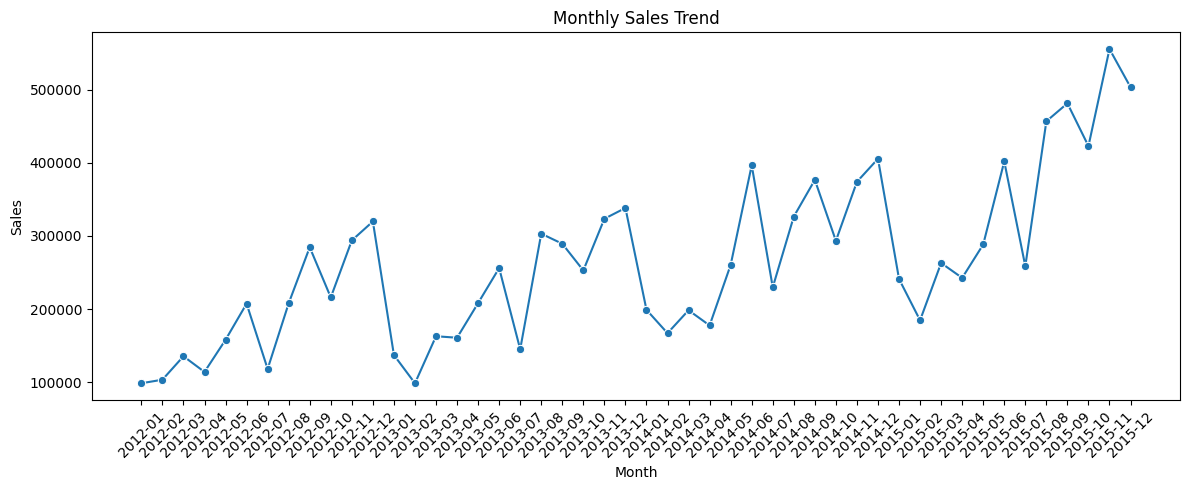

In [38]:
df['Month'] = df['Order Date'].dt.to_period('M').astype(str)

monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.tight_layout()
plt.show()


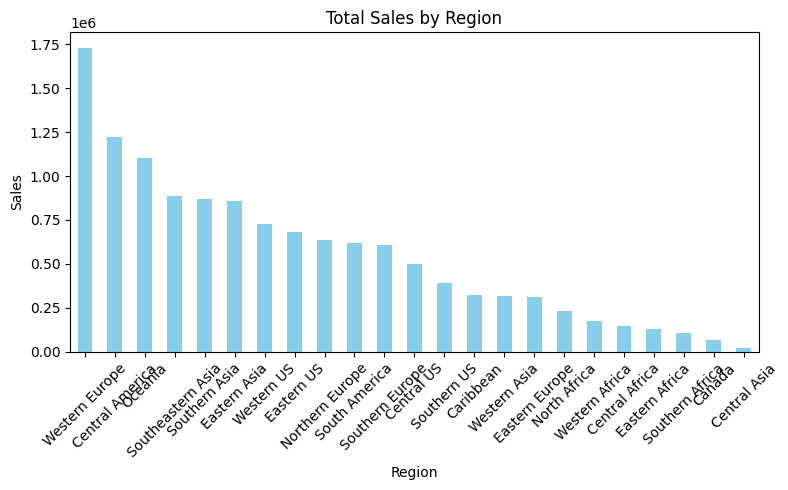

In [39]:
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
region_sales.plot(kind='bar', color='skyblue')
plt.title("Total Sales by Region")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
